In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from fastai import *        # Quick accesss to most common functionality
# from fastai.text import *   # Quick accesss to NLP functionality
import html
from pathlib import Path

In [3]:
import torch.nn as nn

In [4]:
from fastai.text.models.transformer import tfmer_lm_config, GeLU, init_transformer, MultiHeadAttention, PositionalEncoding
from fastai.text.models.awd_lstm import RNNDropout
from fastai.text.learner import LanguageLearner

In [5]:
PATH=Path.home()/'data/wikitext-2-raw'

In [6]:
from fastai.basic_data import *
from fastai.torch_core import *
from fastai.layers import *

In [7]:
bptt = 512
data = load_data(PATH, bs=16, bptt=bptt)

In [8]:
MASK = 'xxmask'
vocab = data.vocab
vocab.itos.append(MASK)

In [9]:
word_range = (0, len(data.vocab.itos))
from fastai.text.transform import *
pad_idx = data.vocab.stoi[PAD]
mask_idx = data.vocab.stoi[MASK]
def bert_tfm(b, word_range=word_range, pad_idx=pad_idx, 
             mask_idx=mask_idx, p=0.2):
    # p = replacement probability
    x_lm,y_lm = b
    x_msk,y_msk = x_lm.clone(),x_lm.clone() # x, x
#     x,y = x.clone(),y.clone()
    rand = torch.rand(x_msk.shape, device=x_lm.device)
    y_msk[rand > p] = pad_idx
    x_msk[rand <= (p*.8)] = mask_idx # 80% = mask
    wrong_word = (rand > (p*.8)) & (rand <= (p*.9)) # 10% = wrong word
    x_msk[wrong_word] = torch.randint(*word_range, [wrong_word.sum().item()], device=x_lm.device)
    return x_msk, y_msk

In [10]:
data.train_dl.tfms = [bert_tfm]
data.valid_dl.tfms = [bert_tfm]

In [11]:

def acc_ignore_pad(input:Tensor, targ:Tensor, pad_idx=pad_idx)->Rank0Tensor:
    n = targ.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targ = targ.view(n,-1)
    mask = targ != pad_idx
    return (input[mask]==targ[mask]).float().mean()

def bert_acc(input:Tensor, b_t:Tensor)->Rank0Tensor:
    return acc_ignore_pad(input, b_t)

In [12]:

class LinearDecoder(nn.Module):
    "To go on top of a RNNCore module and create a Language Model."
    initrange=0.1

    def __init__(self, n_out:int, n_hid:int, tie_encoder:nn.Module=None, bias:bool=True):
        super().__init__()
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        self.decoder.weight.data.uniform_(-self.initrange, self.initrange)
        if bias: self.decoder.bias.data.zero_()
        if tie_encoder: self.decoder.weight = tie_encoder.weight

    def forward(self, input:Tuple[Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs, outputs = input
        decoded = self.decoder(outputs[-1])
        return decoded, raw_outputs, outputs


In [13]:
class DecoderLayer(nn.Module):
    "Basic block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, bias:bool=True):
        super().__init__()
        self.mhra = MultiHeadAttention(n_heads, d_model, d_head, bias=bias)
        self.ff   = feed_forward(d_model, d_inner)
    
    def forward(self, x:Tensor, mask:Tensor=None, **kwargs): 
        attn = self.mhra(x, mask=mask, **kwargs)
        res = self.ff(attn)
        return res

In [14]:

# def feed_forward(d_model:int, d_ff:int, ff_p:float=0., act=nn.ReLU, double_drop:bool=True):
def feed_forward(d_model:int, d_inner:int, ff_p:float=0.1):
    layers = [
        nn.Linear(d_model, d_inner), 
        GeLU(),
        nn.Linear(d_inner, d_model), 
        nn.Dropout(ff_p), 
        MergeLayer(),
        nn.LayerNorm(d_model)
    ]
    return SequentialEx(*layers)


In [15]:
class DownsampleLayer(nn.Module):
    "Basic block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, d_model:int, n_heads:int, d_head:int, ff_p:float=0.1, downsample=True):
        super().__init__()
        
        self.mhra = MultiHeadAttention(n_heads, d_model, d_head, bias=True)
        
        d_inner = d_model*4
        if downsample:
            d_out = d_model * 2
            self.downblock = nn.Conv1d(d_model, d_out, (2), stride=2)
        else:
            self.downblock = None
            d_out = d_model
            
        self.ln1 = nn.Linear(d_out, d_inner)
        self.act = GeLU()
        self.ln2 = nn.Linear(d_inner, d_out)
        self.drop = nn.Dropout(ff_p)
        self.norm = nn.LayerNorm(d_out)

    
    def forward(self, x:Tensor):
        x_attn = self.mhra(x)
        x = x_attn
        
        if self.downblock:
            x_p = x.permute(0, 2, 1)
            x_d = self.downblock(x_p) # bptt x emb x bptt
            x = x_d.permute(0, 2, 1)
        
        x1 = self.ln2(self.act(self.ln1(x)))
        
        x2 = x + x1
        
        return self.norm(self.drop(x2))

In [16]:
class UpsampleLayer(nn.Module):
    "Basic block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, d_model:int, n_heads:int, d_head:int, ff_p:float=0.1, upsample=True):
        super().__init__()
        
        self.mhra = MultiHeadAttention(n_heads, d_model, d_head, bias=True)
        
        d_inner = d_model*4
        if upsample:
            d_out = d_model // 2
            self.upblock = nn.ConvTranspose1d(d_model, d_out, (2), stride=2)
        else:
            d_out = d_model
            self.upblock = None
            
        self.ln1 = nn.Linear(d_out, d_inner)
        self.act = GeLU()
        self.ln2 = nn.Linear(d_inner, d_out)
        self.drop = nn.Dropout(ff_p)
        self.norm = nn.LayerNorm(d_out)

    
    def forward(self, x:Tensor, x_skip:Tensor):
        x_attn = self.mhra(x)
        x = x_attn
        
        if self.upblock:
            x_p = x.permute(0, 2, 1)
            x_u = self.upblock(x_p) # bptt x emb x bptt
            x = x_u.permute(0, 2, 1)
            
        x1 = self.ln2(self.act(self.ln1(x)))
        x2 = self.norm(self.drop(x1))
        return x2 + x_skip

## Transformer

In [17]:
class TransformerConv(nn.Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, vocab_sz:int, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, 
                 embed_p:float=0.1, **kwargs):
        super().__init__()
        self.encoder = nn.Embedding(vocab_sz, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.drop_emb = nn.Dropout(embed_p)
#         self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner) for k in range(n_layers)])
        self.a1 = DownsampleLayer(d_model, n_heads, d_head)
        self.a2 = DownsampleLayer(d_model*2, n_heads, d_head)
        self.a3 = DownsampleLayer(d_model*4, n_heads, d_head, downsample=False)
        self.a4 = UpsampleLayer(d_model*4, n_heads, d_head)
        self.a5 = UpsampleLayer(d_model*2, n_heads, d_head)
    
    def reset(self): pass
    
    def forward(self, x):
        bs, x_len = x.size()
        pos = torch.arange(0, x_len, device=x.device, dtype=x.dtype).float()
        inp = self.drop_emb(self.encoder(x) + self.pos_enc(pos)[None]) #.mul_(self.d_model ** 0.5)
#         mask = torch.triu(x.new_ones(x_len, x_len), diagonal=1).byte()[None,None]
        #[None,:,:None] for einsum implementation of attention
#         for layer in self.layers: inp = layer(inp, mask=mask)
#         print('Inp:', inp.shape)
        x1 = self.a1(inp)
#         print('x1:', x1.shape)
        x2 = self.a2(x1)
#         print('x2:', x2.shape)
        x3 = self.a3(x2)
        x4 = self.a4(x3, x1)
        x5 = self.a5(x4, inp)
        
#         print(x1.shape, x2.shape, x3.shape, x4.shape)
        return ([x5],[x5]) #For the LinearDecoder

In [18]:
class TransformerBase(nn.Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, vocab_sz:int, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, 
                 embed_p:float=0.1, **kwargs):
        super().__init__()
        self.encoder = nn.Embedding(vocab_sz, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.drop_emb = nn.Dropout(embed_p)
        self.layers = nn.ModuleList([DownsampleLayer(d_model, d_head, n_heads, downsample=False) for k in range(n_layers)])
    
    def reset(self): pass
    
    def forward(self, x):
        bs, x_len = x.size()
        pos = torch.arange(0, x_len, device=x.device, dtype=x.dtype).float()
        inp = self.drop_emb(self.encoder(x) + self.pos_enc(pos)[None]) #.mul_(self.d_model ** 0.5)
#         mask = torch.triu(x.new_ones(x_len, x_len), diagonal=1).byte()[None,None]
        for layer in self.layers: inp = layer(inp)
        return ([inp],[inp]) #For the LinearDecoder

In [19]:
vocab_sz = len(data.vocab.itos)
# config = tfmer_lm_config.copy(); config
config = {
    'ctx_len': bptt,
    'n_layers': 4,
    'n_heads': 4,
    'd_model': 128,
    'd_head': 32,
}

In [20]:
# xb,yb = data.one_batch(cpu=False)
# model(xb)

In [24]:
encoder = TransformerBase(vocab_sz, **config)
decoder = LinearDecoder(vocab_sz, config['d_model'], tie_encoder=encoder.encoder, bias=False)
model = nn.Sequential(encoder, decoder)
model.reset = lambda: True
model.apply(init_transformer)
learn = LanguageLearner(data, model, loss_func=CrossEntropyFlat(ignore_index=pad_idx))
learn.metrics = [bert_acc]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


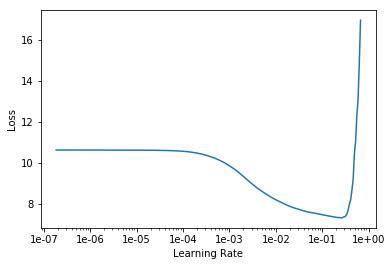

In [25]:
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [26]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,bert_acc,time
0,6.612016,6.361951,0.141403,00:43
1,6.554222,6.308731,0.144479,00:43
2,6.529598,6.302287,0.141995,00:43
3,6.522533,6.286721,0.142608,00:43


In [22]:
encoder = TransformerConv(vocab_sz, **config)
decoder = LinearDecoder(vocab_sz, config['d_model'], tie_encoder=encoder.encoder, bias=False)
model = nn.Sequential(encoder, decoder)
model.reset = lambda: True
model.apply(init_transformer)
learn = LanguageLearner(data, model, loss_func=CrossEntropyFlat(ignore_index=pad_idx))
learn.metrics = [bert_acc]

In [23]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,bert_acc,time
0,6.818747,6.578912,0.137784,00:29
1,6.719836,6.413465,0.171426,00:27
2,6.587164,6.287138,0.180866,00:27
3,6.486319,6.222453,0.181621,00:27
